In [2]:
from src.data.processing import load_datasets, merge_dataframes, save_merged_df, load_merged_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.config.settings import configure_logging
configure_logging()
plt.style.use('fivethirtyeight')

1. Data preparation

In [3]:
# Use this the first time to save the merged data as a .csv file
#customers, transactions = load_datasets()
#df = merge_dataframes(customers, transactions)
#save_merged_df(merged_df=df)

# If you already have merged_sme_data.csv in data/raw, you can load it:
df = load_merged_df()

2025-12-10 09:24:17,225 [INFO] src.data.processing._safe_read_csv: Loading data/raw/merged_sme_data.csv
/app/src/data/processing.py:13: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


In [4]:
# Convert timestamps, sort by time and customer, so it is time-ordered per customer
df['BookingDatetime'] = pd.to_datetime(df['BookingDatetime'])
df = df.sort_values(['cust_id', 'BookingDatetime'])

df['amount_signed'] = df.apply(
    lambda row: row['Amount_EUR'] if row['D_C'] == 'D' else -row['Amount_EUR'],
    axis=1
)

df = df.drop_duplicates(
    subset=['cust_id', 'amount_signed', 'BookingDatetime', 'D_C']
)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['BookingDatetime'].min()} to {df['BookingDatetime'].max()}")
print(f"Unique customers: {df['cust_id'].nunique()}")

#df = df.set_index('BookingDatetime')
df.head()

#daily = df.groupby(['cust_id'])['amount_signed'].resample('D').sum()
#daily = daily.reset_index(name='net_flow')

Dataset shape: (1267435, 19)
Date range: 2023-01-01 00:00:00 to 2024-12-31 23:58:06
Unique customers: 958


,WeekDay,Channel,cust_id,D_C,Currency_trx,Amount_EUR,Customer_IBAN,Counterparty_IBAN,Amount_Orig,currency,MCC,country_of_merchant,BookingDatetime,customer_type,parent_company_flag,CUST_GRP_ID,BRTH_DT,language,amount_signed
3,7,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,C,EUR,0.010024,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,0.010024,EUR,NaN,NaN,2023-01-01 03:56:39,SME,1,NaN,1995-1999,RUS,-0.010024
7,7,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,1.002405,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,7ecc6d620a9ea4170231178c236206770eb7a4785d2a6c...,1.002405,EUR,NaN,NaN,2023-01-08 01:43:51,SME,1,NaN,1995-1999,RUS,1.002405
8,1,ATM,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,C,EUR,3007.214307,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,7ecc6d620a9ea4170231178c236206770eb7a4785d2a6c...,3007.214307,EUR,NaN,NaN,2023-01-16 11:56:38,SME,1,NaN,1995-1999,RUS,-3007.214307
5,1,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,240.577145,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,b4483dd6637ede4ad784b0265188dd2e5441589f261c7b...,240.577145,EUR,NaN,NaN,2023-01-16 13:36:58,SME,1,NaN,1995-1999,RUS,240.577145
6,1,Internet Bank,00feb0ff373287a3b1b210369f5aef9bfffd5d02f6bc8f...,D,EUR,2906.973830,3a8c99d1e8caf60ddbc4b9865b0947f981c90980f3fab2...,375ccaa15fb9358c6e5c90bbe0f1020161e6030ac859d9...,2906.973830,EUR,NaN,NaN,2023-01-16 13:40:50,SME,1,NaN,1995-1999,RUS,2906.973830


In [5]:
def create_features(df, target=None):
    df['hour'] = df['BookingDatetime'].dt.hour
    df['dayofweek'] = df['BookingDatetime'].dt.dayofweek
    df['quarter'] = df['BookingDatetime'].dt.quarter
    df['month'] = df['BookingDatetime'].dt.month
    df['year'] = df['BookingDatetime'].dt.year
    df['dayofyear'] = df['BookingDatetime'].dt.dayofyear
    df['dayofmonth'] = df['BookingDatetime'].dt.day

    lags = [1,7,14,30]
    lag_cols = []
    for l in lags:
        col_name = f'lag_{l}'
        df[col_name] = df.groupby('cust_id')['net_flow'].shift(l)
        lag_cols.append(col_name)

    windows = [7,14,30]
    roll_cols = []
    for w in windows:
        mean_col = f'roll_mean_{w}'
        std_col = f'roll_std_{w}'
        df[mean_col] = df.groupby('cust_id')['net_flow'].shift(1).rolling(w).mean()
        df[std_col] = df.groupby('cust_id')['net_flow'].shift(1).rolling(w).std()
        roll_cols.extend([mean_col, std_col])

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth'] + lag_cols + roll_cols]

    if target:
        y = df[target]
        return X, y
    return X


Testing 1 customer model

In [6]:
cust_id = df.iloc[0]['cust_id']
ts = df.loc[df['cust_id'] == cust_id]
ts = ts.set_index('BookingDatetime')
ts_daily = ts.groupby(['cust_id'])['amount_signed'].resample('D').sum()
ts_daily = ts_daily.reset_index(name='net_flow')
train_val, test = train_test_split(ts_daily, test_size=0.2)

train, val = train_test_split(train_val, test_size=0.25)

X_train, y_train = create_features(train, target='net_flow')
X_val, y_val = create_features(val, target='net_flow')
X_test, y_test = create_features(test, target='net_flow')

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {'max_depth': 6, 'eta': 0.5}
evals_list = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(params=params, dtrain=dtrain, evals=evals_list, early_stopping_rounds=50)

[0]	train-rmse:446.58409	validation-rmse:999.65157
[1]	train-rmse:340.27603	validation-rmse:1026.25446
[2]	train-rmse:253.00097	validation-rmse:1073.72091
[3]	train-rmse:204.40883	validation-rmse:1107.98292
[4]	train-rmse:168.36371	validation-rmse:1117.65124
[5]	train-rmse:149.87509	validation-rmse:1116.75162
[6]	train-rmse:130.26697	validation-rmse:1123.91667
[7]	train-rmse:111.46791	validation-rmse:1129.75121
[8]	train-rmse:100.62218	validation-rmse:1131.68573
[9]	train-rmse:94.73945	validation-rmse:1132.83047


In [8]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
        )

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

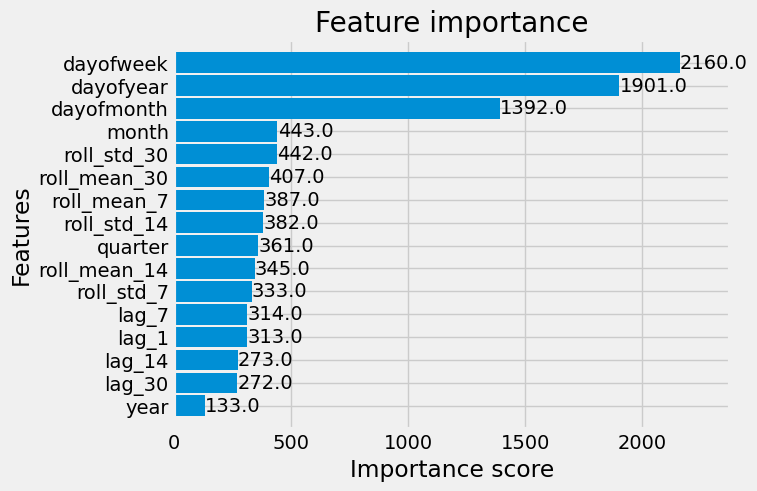

In [9]:
_ = plot_importance(reg, height=0.9)

In [10]:
test['prediction'] = reg.predict(X_test)
mean_absolute_error(test['net_flow'], test['prediction'])

928.8943287042931

Testing mlforecast library

In [11]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

In [12]:
series = pd.DataFrame({
    "ds": df['BookingDatetime'],
    "unique_id": df['cust_id'],
    "y": df['amount_signed']
})

# Convert ds to datetime and extract just the date
#series['ds'] = pd.to_datetime(series['ds'])
series['date_only'] = series['ds'].dt.date

# Get all unique customer-date combinations that exist
existing_dates = series.groupby(['unique_id', 'date_only']).size().reset_index()[['unique_id', 'date_only']]

# For each customer, get their date range and create missing dates
all_rows = []
min_date = series['date_only'].min()
max_date = series['date_only'].max()

for customer in series['unique_id'].unique():
    customer_data = series[series['unique_id'] == customer]
    
    # Get date range for this customer
    #min_date = customer_data['date_only'].min()
    #max_date = customer_data['date_only'].max()
    
    # Create all dates in range
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D').date
    
    # Find missing dates
    existing = set(customer_data['date_only'].unique())
    missing_dates = [d for d in all_dates if d not in existing]
    
    # Add rows for missing dates with y=0
    for missing_date in missing_dates:
        all_rows.append({
            'ds': pd.Timestamp(missing_date),
            'unique_id': customer,
            'y': 0
        })

# Create DataFrame from missing dates and concatenate with original
missing_df = pd.DataFrame(all_rows)
series_complete = pd.concat([series[['ds', 'unique_id', 'y']], missing_df], ignore_index=True)

# Sort by customer and datetime
series_complete = series_complete.sort_values(['unique_id', 'ds']).reset_index(drop=True)

In [13]:
cutoff = pd.to_datetime('2024-11-01')

train_df = series_complete[series_complete['ds'] < cutoff].copy()
test_df  = series_complete[series_complete['ds'] >= cutoff].copy()


In [14]:
def aggregate_to_daily(df):
    df = df.set_index('ds')
    df = df.groupby(['unique_id'])['y'].resample('D').sum()
    df = df.reset_index(name='y')
    return df

#train_df = aggregate_to_daily(train_df)
#test_df = aggregate_to_daily(test_df)

In [15]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
    XGBRegressor(),
]

fcst = MLForecast(
    models=models,
    freq='d',
    lags=[7,14],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=14)] # RollingMean(window_size=28) larger window = less training data
    },
    date_features=['dayofweek', 'dayofyear', 'month', 'hour'], #, 'day'
    target_transforms=[Differences([1])]
)

In [16]:
fcst.fit(train_df)

MLForecast(models=[LGBMRegressor, LinearRegression, XGBRegressor], freq=d, lag_features=['lag7', 'lag14', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size14'], date_features=['dayofweek', 'dayofyear', 'month', 'hour'], num_threads=1)

In [17]:
preds = fcst.predict(60)

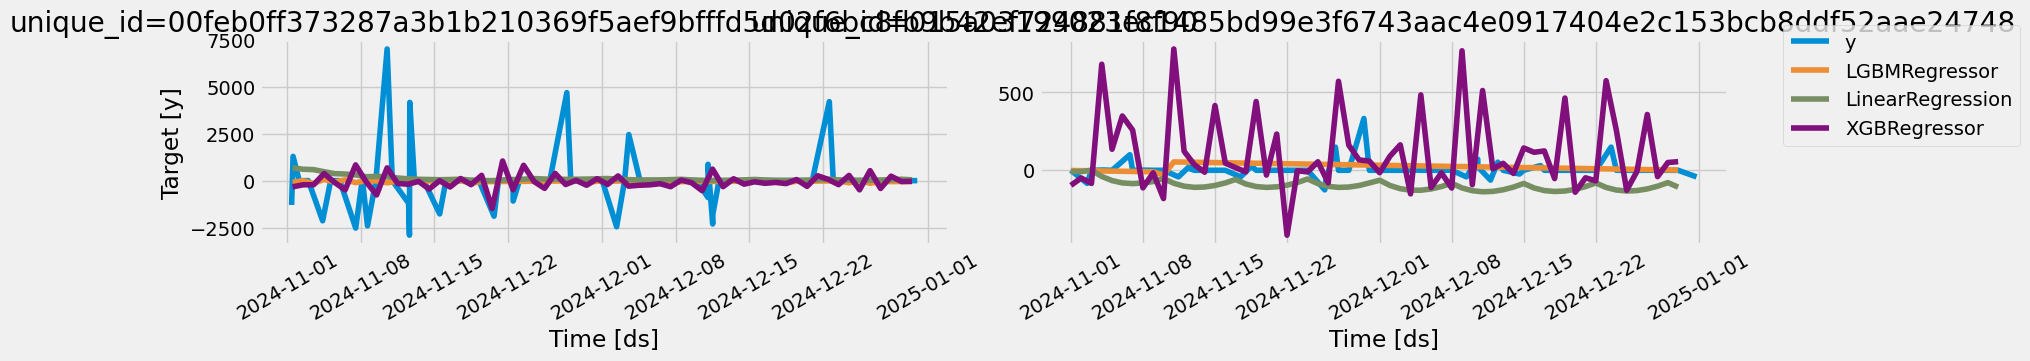

In [19]:
from utilsforecast.plotting import plot_series

fig = plot_series(test_df, preds, max_ids=2, plot_random=False)
fig

Testing statistical models

In [ ]:
# Test using a subset
uids = train_df['unique_id'].unique()[:10]
train_df_sub = train_df.query('unique_id in @uids')
test_df_sub = test_df.query('unique_id in @uids')

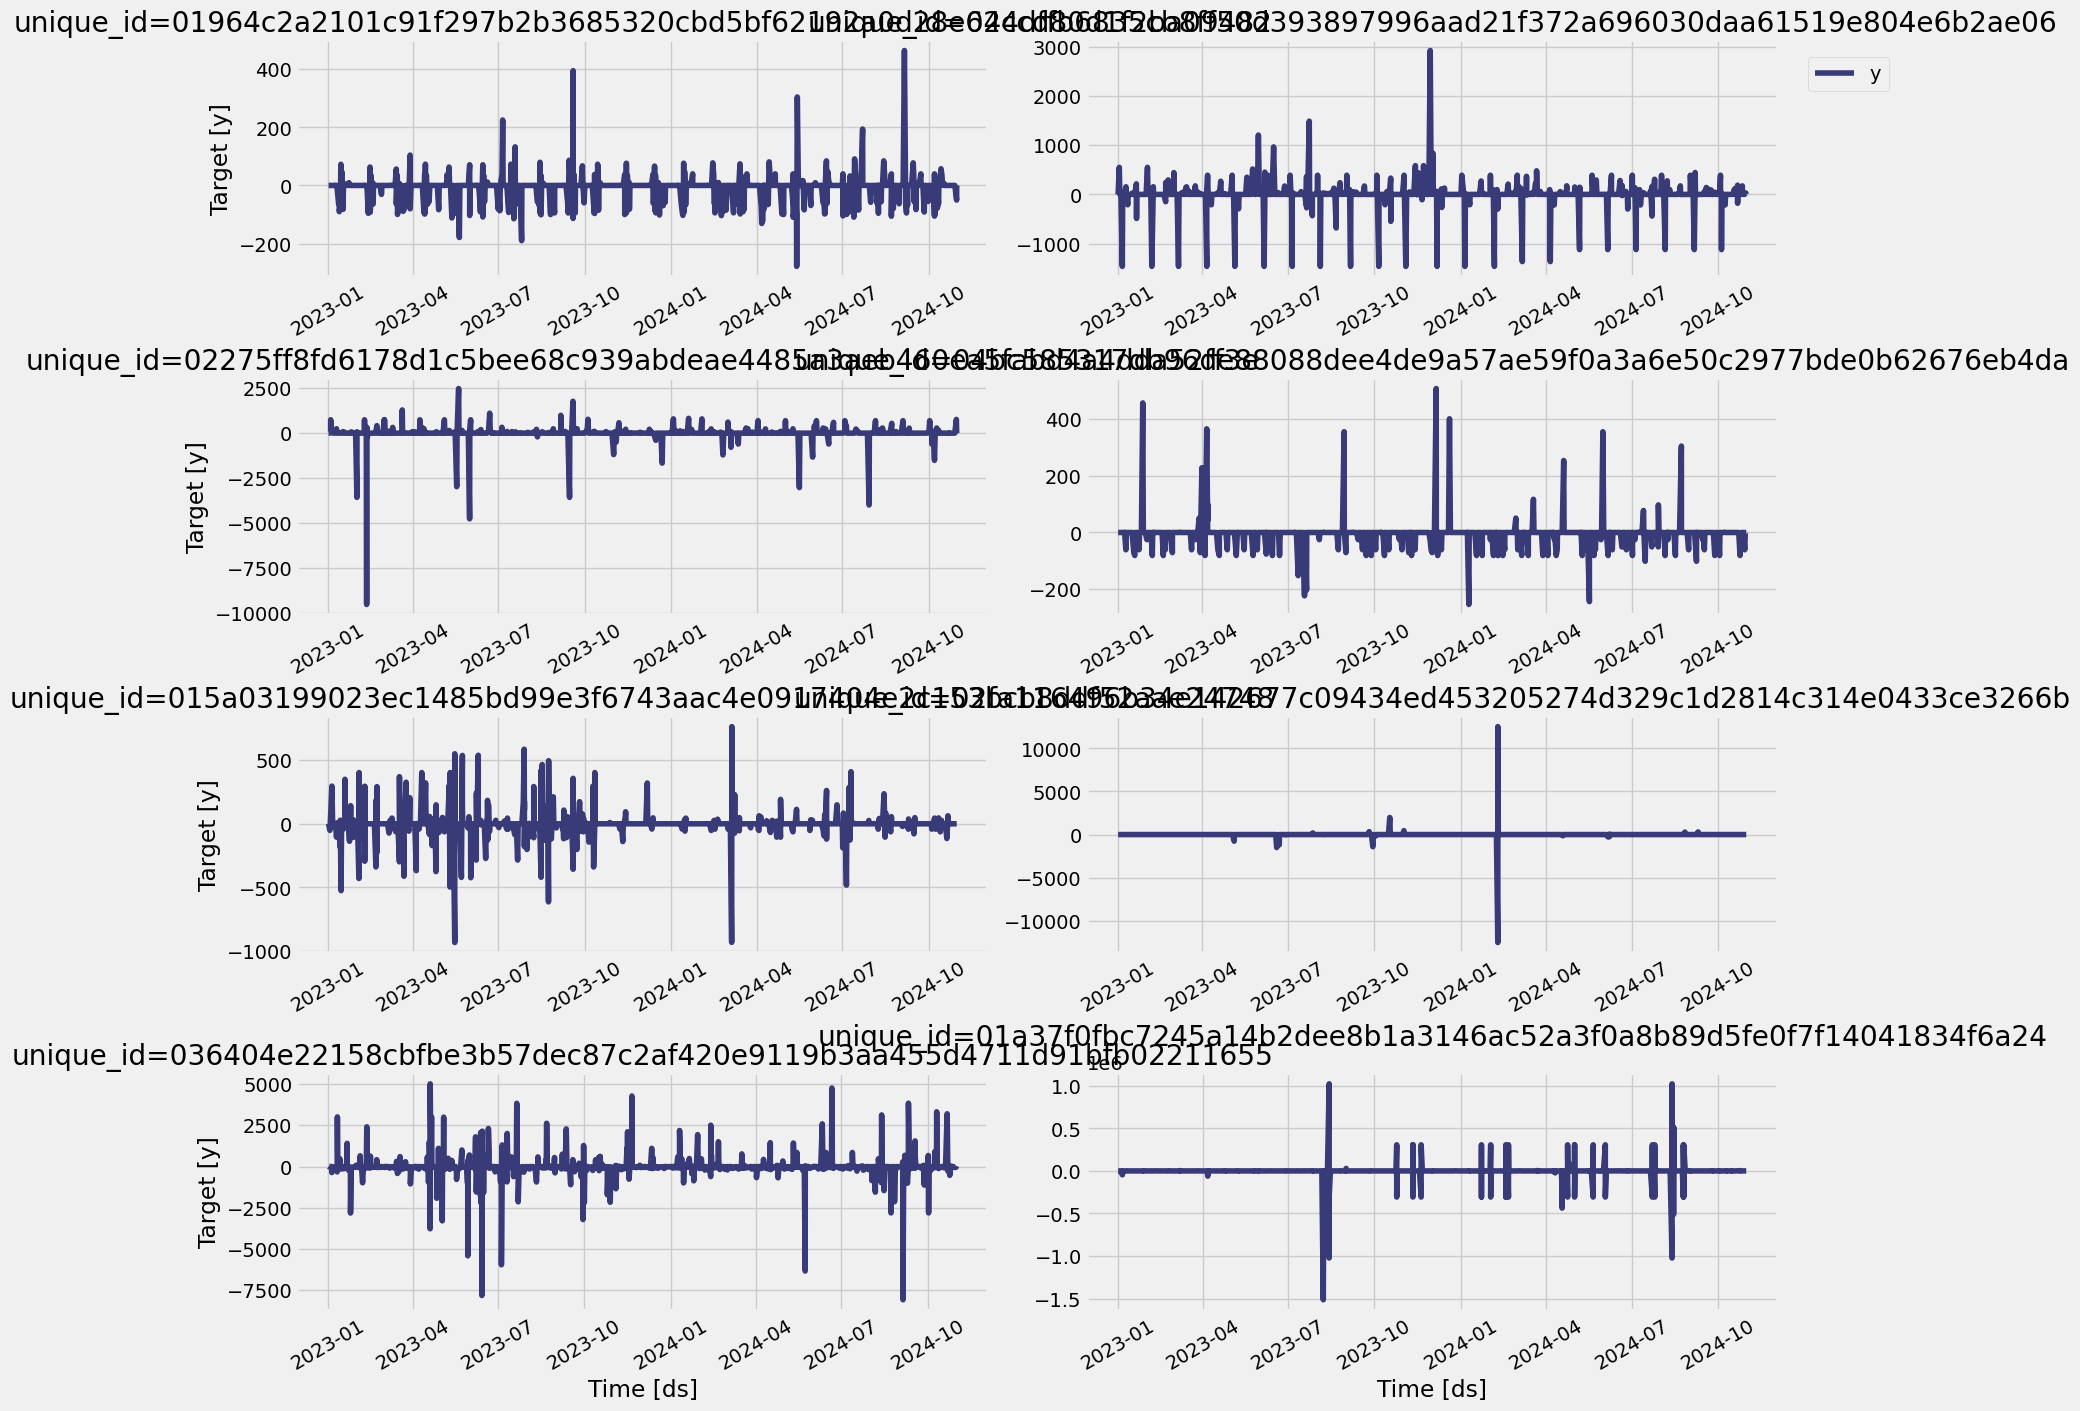

In [106]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, AutoARIMA, HoltWinters, HistoricAverage

StatsForecast.plot(train_df_sub)

In [107]:
models = [
    SeasonalNaive(season_length=180), # how far back to look, setting this is tricky
    HistoricAverage()
    #AutoARIMA(season_length=60) # too intensive for local pc
    #HoltWinters(season_length=180)
]

sf = StatsForecast(
    models=models,
    freq='d',
    fallback_model = SeasonalNaive(season_length=7),
    n_jobs=-1
)

sf.fit(train_df)

StatsForecast(models=[SeasonalNaive,HistoricAverage])

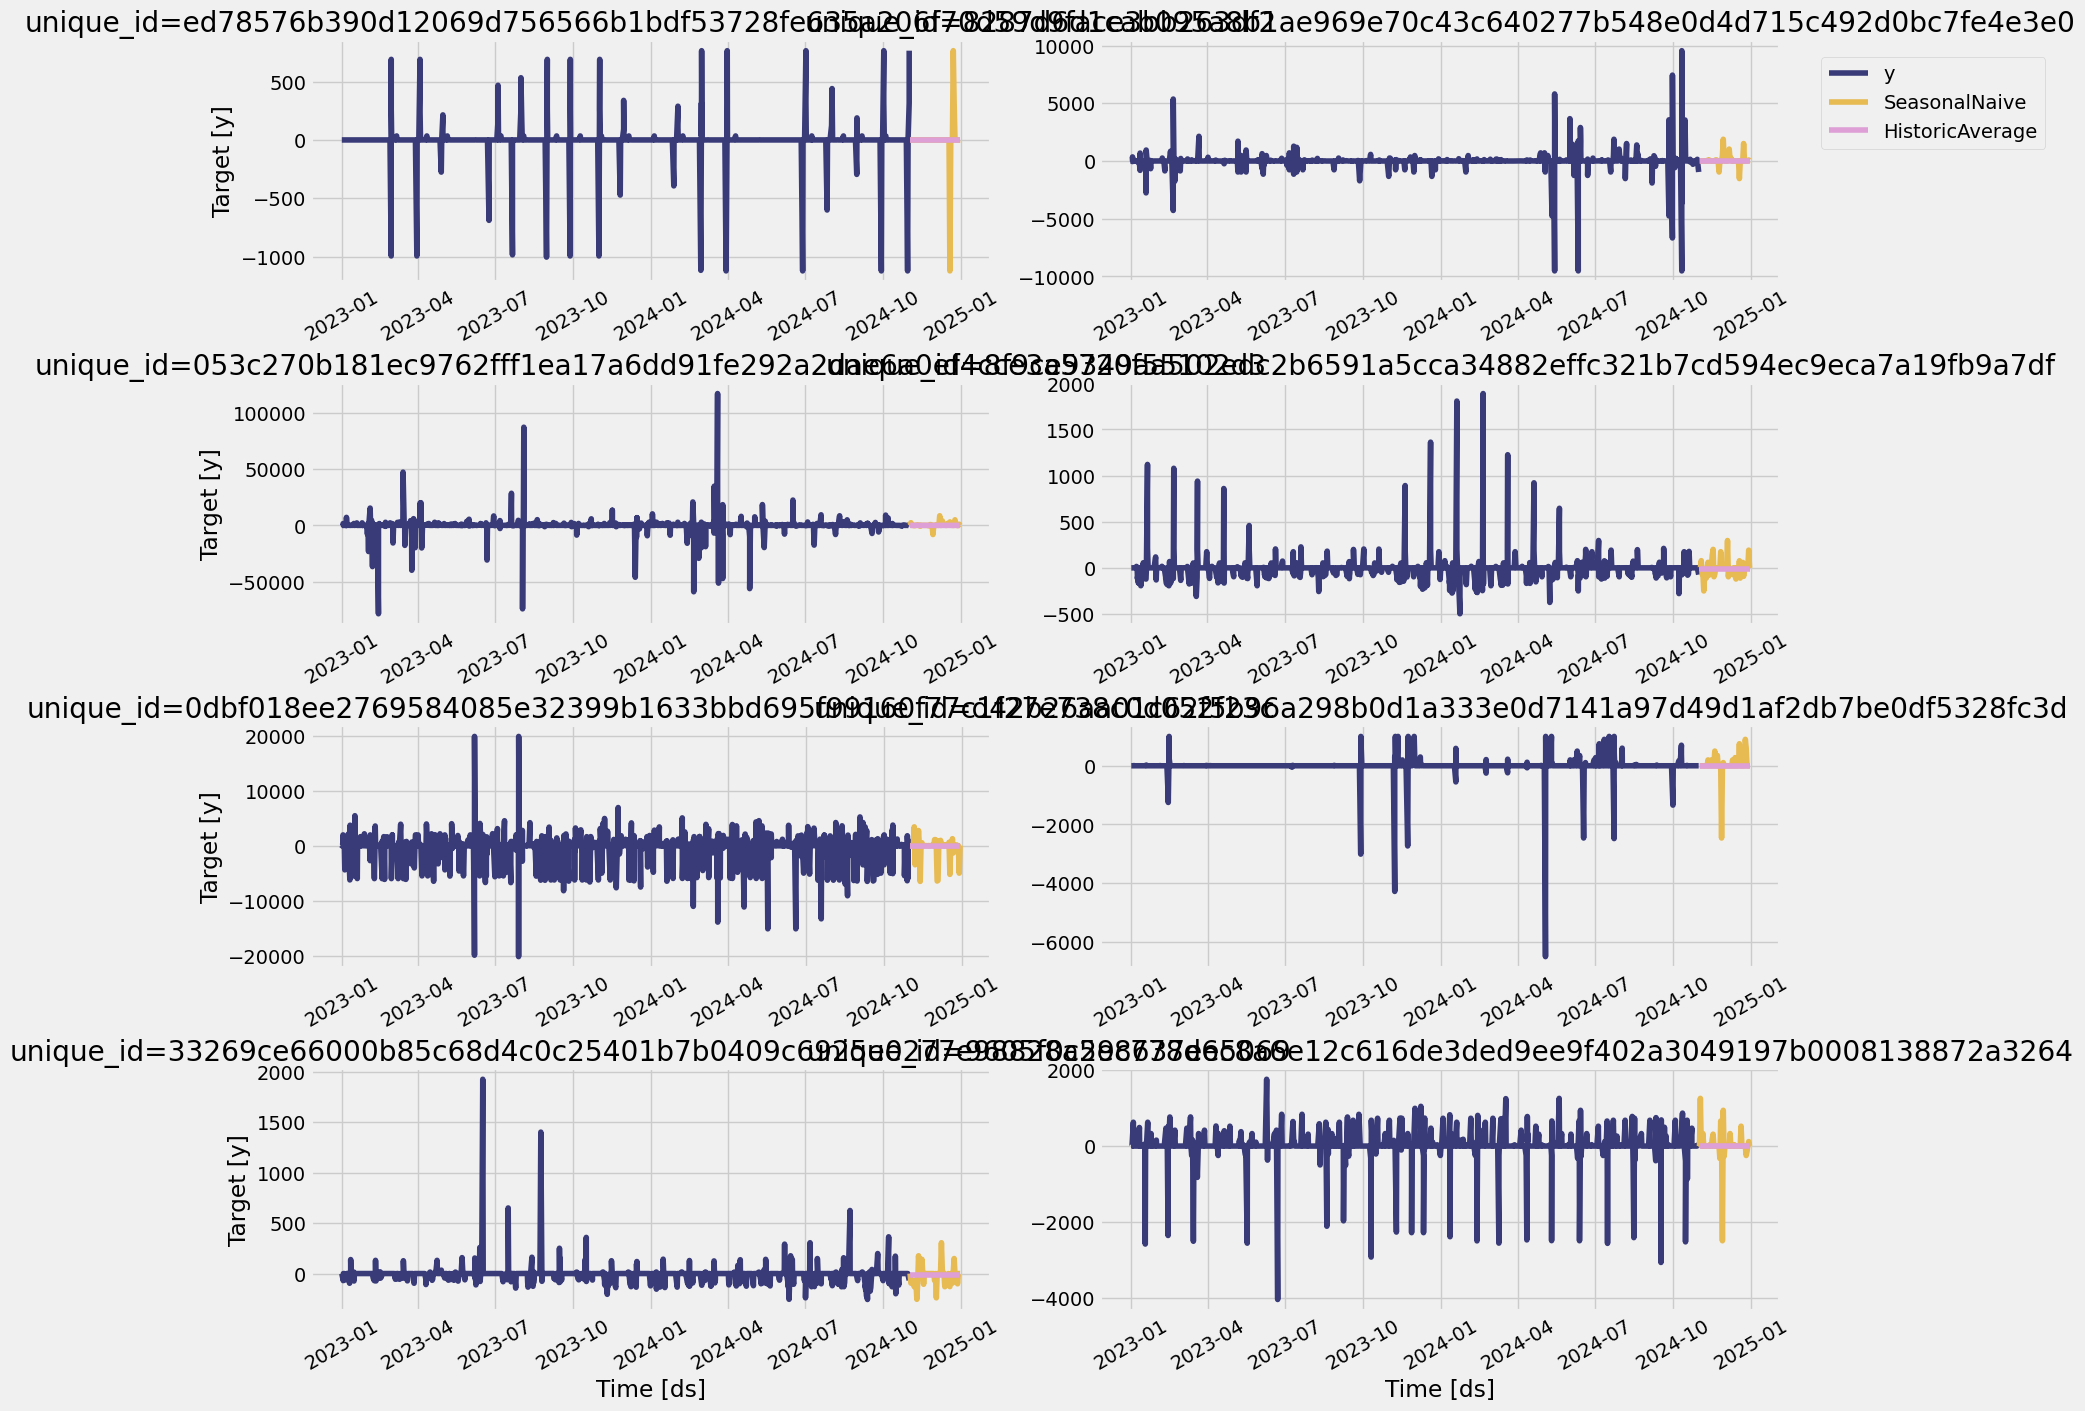

In [113]:
forecasts_df = sf.forecast(df=train_df, h=60) # h: forecast horizon, level=[90]: model expects the real value to be inside that interval 90% of the times
sf.plot(train_df, forecasts_df)